In [1]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/Principle of Machine Learning/"

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Principle of Machine Learning/")
os.listdir()

['meme.jpg',
 'Ch 5 SVM Lab.ipynb',
 'Ch 8 Exercise 9.ipynb',
 'Ch 9 Unsupervised Learning Lab.ipynb',
 'Ch 7 Ensemble Lab.ipynb',
 'Ch 10 Exercise 1.gdoc',
 'MLP 03_classification_student.ipynb',
 'Ch 11 Exercise .ipynb8',
 'Ch 12 Exercise 12.ipynb',
 'aclImdb_v1.tar.gz',
 'Ch 13 Exercise 10.ipynb',
 'creditcard.csv',
 'Project Presentation.gslides',
 'Ch 14 Computer Vision.ipynb',
 'logs',
 'Empirical Evidence.ipynb',
 'autoencoder_fraud.h5',
 'V1.png',
 'Final Presentation.gslides',
 'fraud-detection-using-autoencoders-in-keras.ipynb',
 'Untitled0.ipynb']

# Autoencoders and Why You Should Use Them
Autoencoders are a type of neural network that takes an input (e.g. image, dataset), boils that input down to core features, and reverses the process to recreate the input. Although it may sound pointless to feed in input just to get the same thing out, it is in fact very useful for a number of applications. The key here is that the autoencoder boils down (encodes) the input into some key features that it determines in an unsupervised manner. Hence the name "autoencoder" — it automatically encodes the input.

It is the assumption in using autoencoders that fraud or anomalies will suffer from a detectably high reconstruction error.

In [3]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

In [4]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

# Import and Check Data
The data contains 284,807 European credit card transactions that occurred over two days with 492 fraudulent transactions. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns.

In [5]:
df = pd.read_csv("creditcard.csv")

In [6]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape

(284807, 31)

In [8]:
# No of null values in dataset
df.isnull().values.sum()

0

Indeed the data seems to be cleaned and loaded as we expect. Now we want to check if we have the expected number of normal and fraudulent rows of data. We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [9]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64


The counts are as expected (284,315 normal transactions and 492 fraud transactions). As is typical in fraud and anomaly detection in general, this is a very unbalanced dataset.

# Exploratory Data Analysis

## Balance of Data Visualization
Let's get a visual confirmation of the unbalanced data in this fraud dataset.

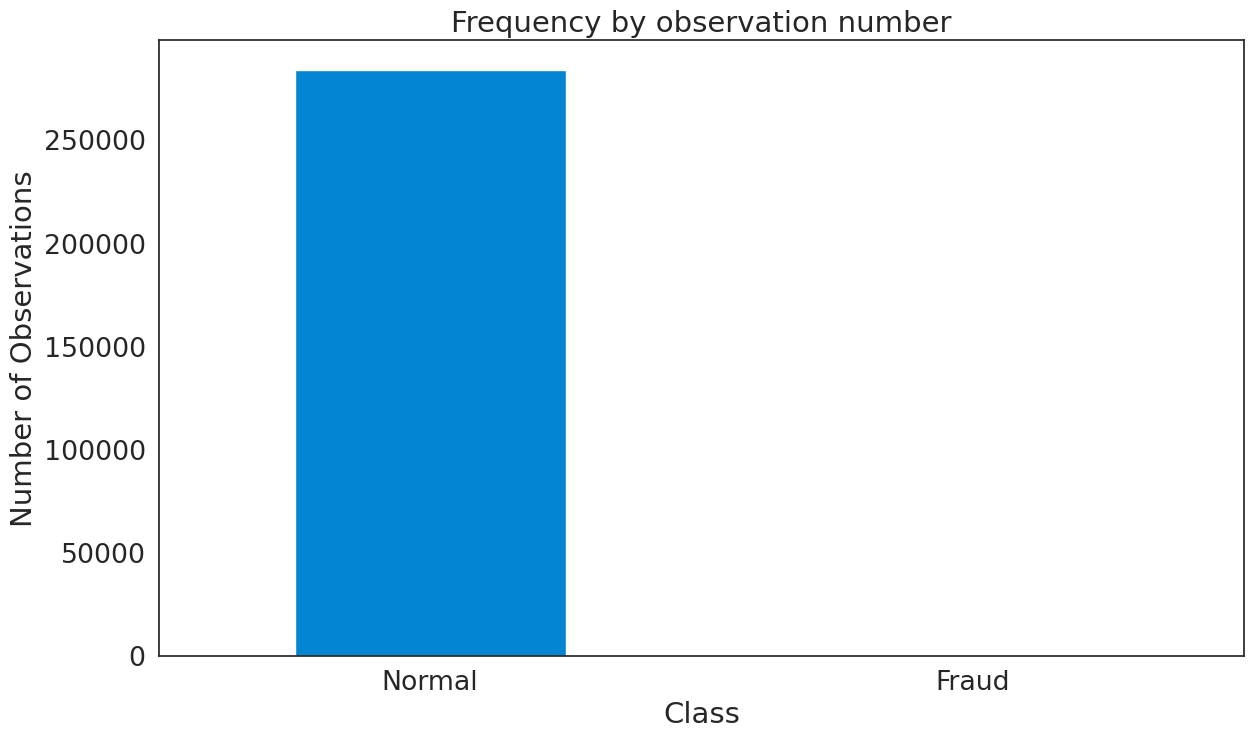

In [10]:
# The classes are heavily skewed
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

## Summary Statistics of the Transaction Amount Data
We will cut up the dataset into two data frames, one for normal transactions and the other for fraud.

In [11]:
normal_df = df[df['Class']==0]
fraud_df = df[df['Class']==1]

In [12]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

## Visual Exploration of the Transaction Amount Data

In anomaly detection datasets it is common to have the areas of interest "washed out" by abundant data. In this dataset,  a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc). This abundant data is likely to wash out the rest of the data, so looking at transactions which are $200+

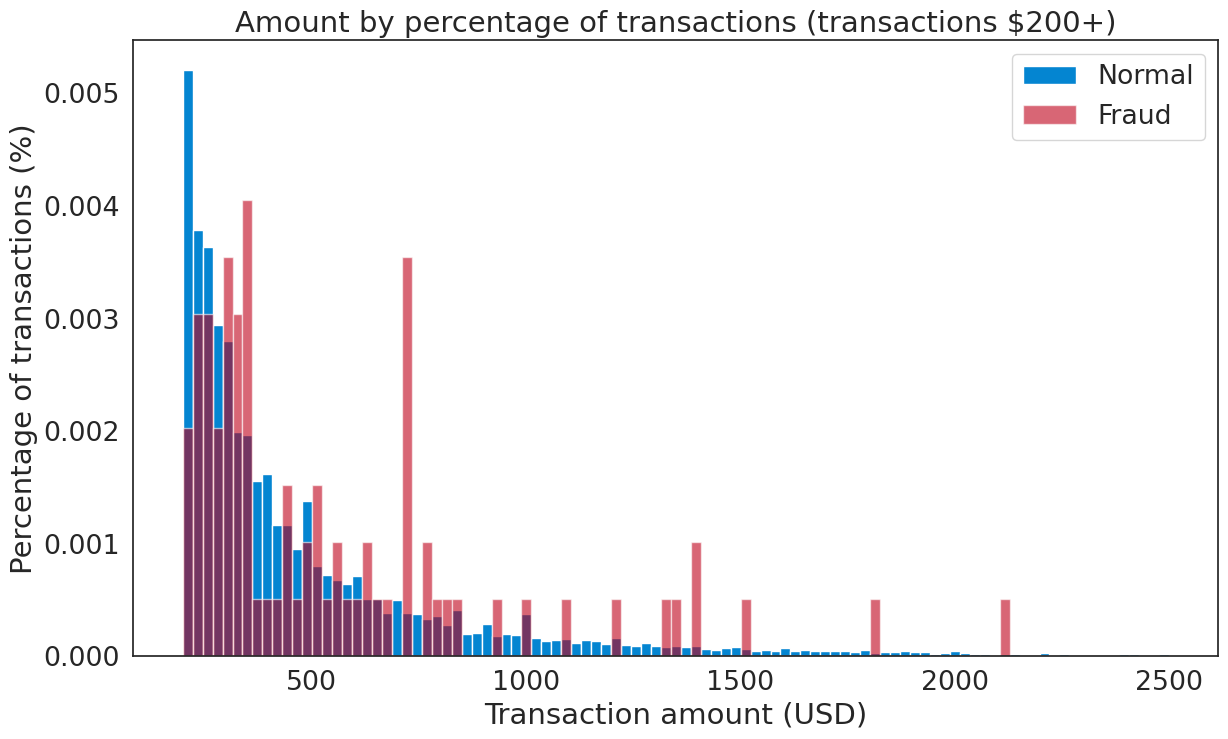

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

"""Most transactions are small amounts, less than 100. Fraudulent transactions have a maximum value far less than normal transactions, $2,125.87 vs $25,691.16."""

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable. In the long tail, especially, we are likely observing only a single fraud transaction. It would be hard to differentiate fraud from normal transactions by transaction amount alone.

## Visual Exploration of the Data by Hour

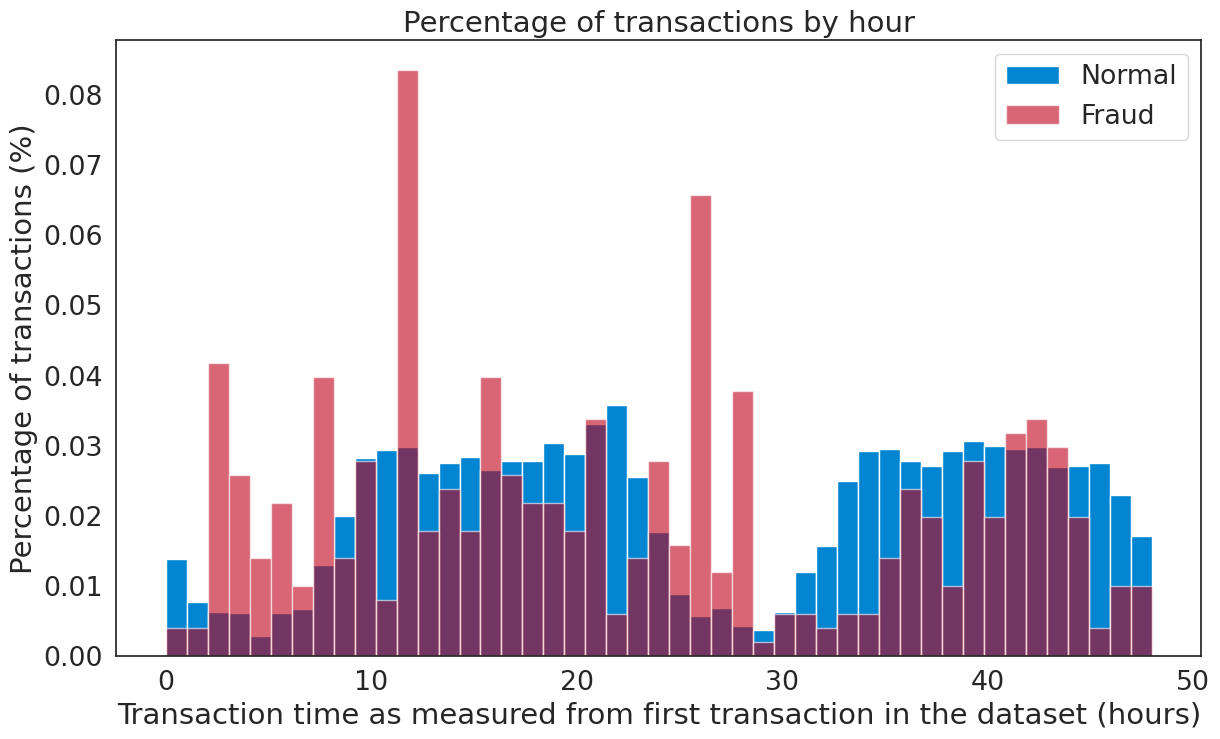

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

"""The 'Time' feature looks pretty similar across both types of transactions. You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time."""

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, I am assuming those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again, however, the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier.

## Visual Exploration of Anonmyzed Features

In [ ]:
from google.colab import files
from IPython.display import clear_output


#Select only the anonymized features.
v_features = df.iloc[:,1:29].columns

for i, cn in enumerate(df[v_features]):
  plt.figure(figsize=(12,28*4))
  gs = gridspec.GridSpec(28, 1)
  ax = plt.subplot(gs[i])
  sns.distplot(df[cn][df.Class == 1], bins=50)
  sns.distplot(df[cn][df.Class == 0], bins=50)
  ax.set_xlabel('')
  ax.set_title('histogram of feature: ' + str(cn))
  plt.show()


# Model Setup: Basic Autoencoder
Now that more simplistic methods are not proving that useful, we are justified in exploring our autoencoder to see if it does a little better.

## Normalize and Scale Data

Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. It is therefore common to scale the data to similar magnitudes. As most of the data (other than 'time' and 'amount') result from the product of a PCA analysis. The PCA done on the dataset transformed it into standard-normal form. I will do the same to the 'time' and 'amount' columns.

In [17]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

## Dividing Training and Test Set
Now we split the data into training and testing sets according to the percentage and with a random seed we wrote at the beginning of the code.

In [18]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
temp = train_x[train_x.Class == 1]
train_x, val_x = train_test_split(train_x, test_size=TEST_PCT, random_state=RANDOM_SEED)

train_x = train_x[train_x.Class == 0]       # where normal transaction
train_x = train_x.drop(['Class'], axis=1)   # drop the class column

val_y = val_x['Class']
val_x = val_x.drop(['Class'], axis=1)

test_x = pd.concat([test_x, temp])
test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
val_x = val_x.values                        # transform to ndarray
test_x = test_x.values                      # transform to ndarray

# Creating The Model

## Autoencoder Layer Structure and Parameters
Autoencoder has symmetric encoding and decoding layers that are "dense".
We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [19]:
nb_epoch = 50
batch_size = 512
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 24
hidden_dim1 = 20 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 16
hidden_dim3 = 12
learning_rate = 1e-7

In [20]:

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument,
# kernel is a weights matrix created by the layer, and
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
autoencoder = Sequential([
  # This returns a tensor
  Input(shape=(input_dim, )),
  Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l2(learning_rate)),
  Dense(hidden_dim1, activation="relu"),
  Dense(hidden_dim2, activation="relu"),
  Dense(hidden_dim3, activation="relu"),

  Dense(hidden_dim3, activation='relu'),
  Dense(hidden_dim2, activation='relu'),
  Dense(hidden_dim1, activation='relu'),
  Dense(input_dim, activation='relu'),
])
# This creates a model that includes
# the Input layer and four Dense layers
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                744       
                                                                 
 dense_1 (Dense)             (None, 20)                500       
                                                                 
 dense_2 (Dense)             (None, 16)                336       
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 16)                208       
                                                                 
 dense_6 (Dense)             (None, 20)                3

## Model Training and Logging
Below is where we set up the actual run including checkpoints and the tensorboard.

In [21]:
def weighted_mse(y_true, y_pred):
    mse = tf.keras.backend.mean(tf.math.square(y_true - y_pred), axis=-1)
    weighted_mse = tf.reduce_sum(10 * mse)
    return weighted_mse

# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['acc'],
                    loss=weighted_mse)

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard,
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(val_x, val_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
354/356 [============================>.] - ETA: 0s - loss: 4692.2979 - acc: 0.3487

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


356/356 [==============================] - 6s 11ms/step - loss: 4688.5464 - acc: 0.3490 - val_loss: 4365.5322 - val_acc: 0.4767
Epoch 2/50
356/356 [==============================] - 2s 4ms/step - loss: 4200.2446 - acc: 0.4956 - val_loss: 4206.4570 - val_acc: 0.5191
Epoch 3/50
356/356 [==============================] - 2s 5ms/step - loss: 4098.1572 - acc: 0.5293 - val_loss: 4141.0972 - val_acc: 0.5424
Epoch 4/50
356/356 [==============================] - 2s 4ms/step - loss: 4028.4429 - acc: 0.5467 - val_loss: 4075.1438 - val_acc: 0.5623
Epoch 5/50
356/356 [==============================] - 2s 4ms/step - loss: 3966.8354 - acc: 0.5798 - val_loss: 4020.4746 - val_acc: 0.5967
Epoch 6/50
356/356 [==============================] - 2s 5ms/step - loss: 3929.6162 - acc: 0.6028 - val_loss: 4004.8545 - val_acc: 0.6024
Epoch 7/50
356/356 [==============================] - 2s 4ms/step - loss: 3900.4143 - acc: 0.6132 - val_loss: 3952.9897 - val_acc: 0.6172
Epoch 8/50
356/356 [========================

In [22]:
# Visualizing metrics on local system
# !tensorboard --logdir='logs'

In [23]:
autoencoder = load_model('autoencoder_fraud.h5', custom_objects={'weighted_mse': weighted_mse})

# Model Evaluation

## Model Loss
The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.

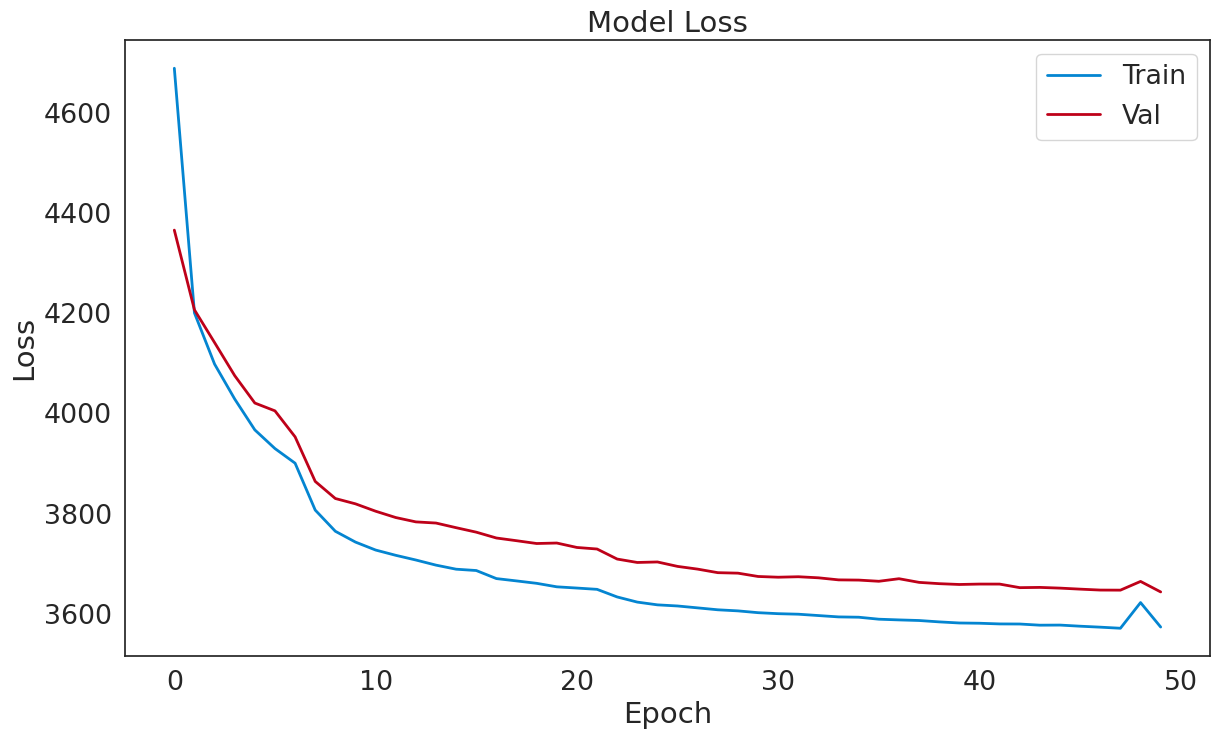

In [24]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Val')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below:

In [25]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

1792/1792 [==============================] - 4s 2ms/step


,Reconstruction_error,True_class
count,57339.000000,57339.000000
mean,0.881898,0.008581
std,4.705821,0.092234
min,0.052878,0.000000
25%,0.243942,0.000000
50%,0.381577,0.000000
75%,0.600158,0.000000
max,260.060909,1.000000


## Recall vs. Precision Thresholding
Now let's look at recall vs. precision to see the trade-off between the two.


Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

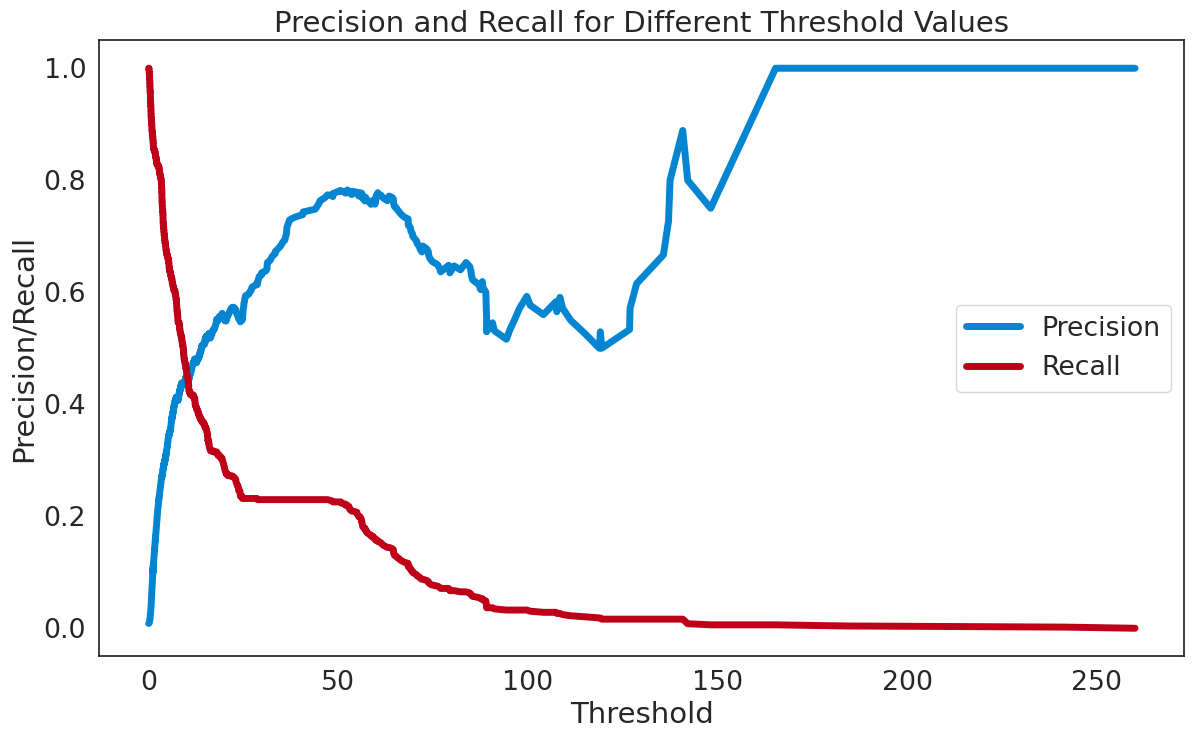

In [28]:
plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and Recall for Different Threshold Values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


## Reconstruction Error vs Threshold Check

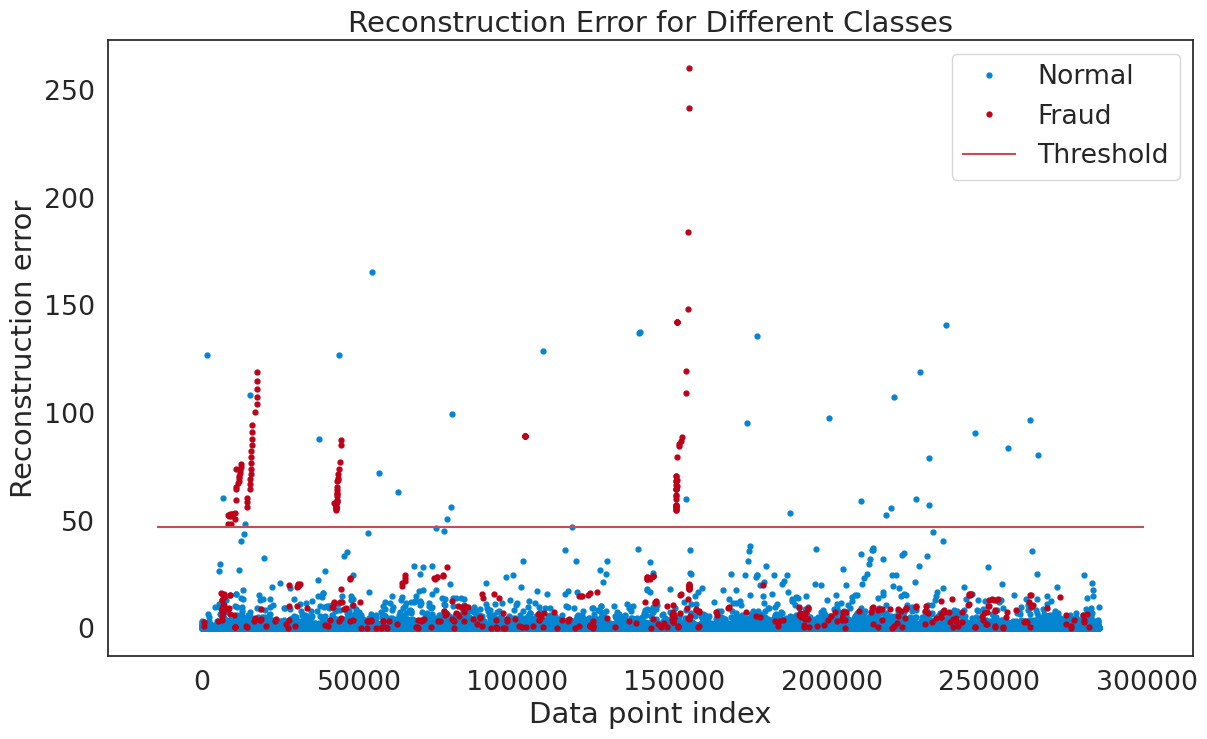

In [29]:
threshold_fixed = 47

groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Different Classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Confusion Matrix
Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision.

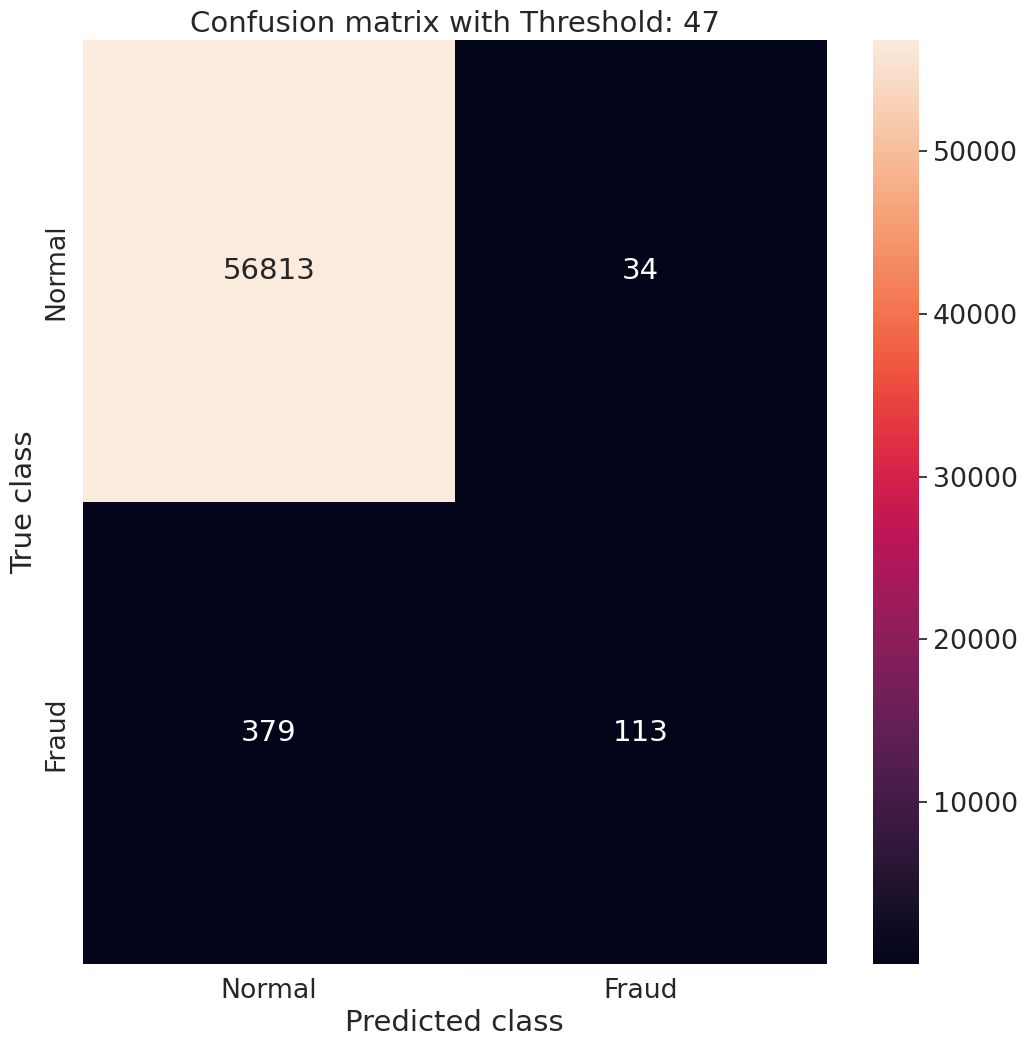

In [30]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix with Threshold: " + str(threshold_fixed))
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Source: [datascience.com](http://www.datascience.com/blog/fraud-detection-with-tensorflow?utm_medium=email&_hsenc=p2ANqtz-9IZ7jpDKVn9-SJB_tVIKpBXp3QVcAC6cZivlugt6ptH8oHWCgodII9b0b_uC-Wyz3oVoXiPn4eBfDfEXqVPbPhHw1SaA&_hsmi=65196762&utm_content=65196762&utm_source=hs_email&hsCtaTracking=ed11a1c4-fe1e-4029-9f9c-fe0f8f753f9c%7C1d08bcf9-3f15-4273-a51c-a8369b589fe4)

In [31]:
[tn, fp], [fn, tp] = conf_matrix
p = tp/(tp+fp)
r = tp/(tp+fn)
print("precision: " + str(p))
print("recall: " + str(r))
print("f1: " + str(2*p*r/(p+r)))

precision: 0.7687074829931972
recall: 0.22967479674796748
f1: 0.3536776212832551
